In [11]:
# Importing the required libraries for dataset operations 
## These are the liberaries used to run LSTM Model. 
## Keras lib provides accruate results in Machine learning. LSTM is the predictive model 
## RMSE is used for evaluate the error
from numpy import array
from pandas import read_csv
from math import sqrt
from numpy import split

# for Deeping learning LSTM 
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import Flatten
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense

In [12]:
# loading the power consumption dataset of a household
## Reading the household Power consumption file, which is already cleaned with missing values and resampled it for days.
## Choosing index column as datetime because it is Time series data set
## Its is having dates so parse dates is true

df = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [13]:
## Now its in days reading
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [14]:
df.shape

(1442, 8)

In [9]:
df.info

<bound method DataFrame.info of             Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   
...                         ...                    ...        ...   
2010-11-22             2041.536                142.354  345883.85   
2010-11-23             1577.536                137.450  346428.76   
2010-11-24             1796.248                132.460  345644.59   
2010-11-25             1431.164                116.128  347812.21   
2010-11-26             1488.104                120.826  303487.57   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_mete

In [15]:
## Separate in Training and testing dataset into standard weeks, these weeks begin on Sunday and end on Saturday.
## Lets consider for training set starting from year 2006 to 2009. 
## Lets consider for testing set for the year 2010
## Data for Training (Only data of 159 weeks, Starting from December 17, 2006(first Sunday) till end of the week in 2009) 
## Data for Testing (Only data of 46 weeks, Starting from Jan 3, 2010(first Sunday) till end of the week in 2010)
# split a dataset into train/test sets


def split_df(df):
    
    # fucntion to split the df into standard weeks 
    
    train, test = df[1:-328], df[-328:-6]
    
    # assigning into weekly basis by divinding by 7 days
    
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    
    return train, test

In [16]:
# split into train and test
train, test = split_df(df.values)

In [17]:
train.shape

(159, 7, 8)

In [18]:
test.shape

(46, 7, 8)

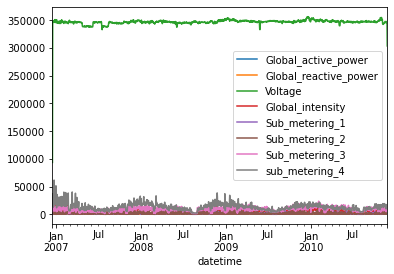

In [20]:
df.plot()

In [ ]:
## So the number of weeks for training set is 159 and for testing set is 46

In [6]:
## This involves framing the dataset as supervised learning problem.
## Framing the supervised learning problem as predicting the power consumption and  convert history into inputs and outputs
# Sequence is given so that the output of the first week prediction will be added to the second week: for example
# week 1, input_end = 0 + we provide input as 7 days this give value for week 2
# then week 1+ week2 = week 3,
# then week 1+ week2 + week3 = week4 , This how the formula works. LSTM needs to be reshaped.# same procedure will follow for y values and it is stored in array x and array y
def supervised_model(train, we_input, we_output=7): 
    df= train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    X, y= list(), list()
    input_start = 0
    for _ in range(len(df)):
        input_end= input_start + we_input
        output_end= input_end + we_output
        if output_end <= len(df):
            x_input= df[input_start: input_end, 0]
            x_input= x_input.reshape((len(x_input),1))
            X.append(x_input)
            y.append(df[input_end:output_end,0])
        input_start+= 1
    return array(X), array(y)    
   

In [8]:
## Same model we built for 24hrs prediction only changes is here we added dense layer 100. 
## Define LSTM with 200 neurons in the first hidden layer and 1 neuron in the output layer for predicting power consumption.
## The input shape will 1 time step with 8 features 
## Using Mean Absolute error(MSE) loss function and the efficient adam version stochastic gradient descent 
## The model will be fit for 70 training epchos with a batch size of 16. 
##ref https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
# to prepare training data by creating LSTM model
def LSTM_model(train,we_input):
    train_xset,train_yset= supervised_model(train,we_input)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(train_xset.shape[1], train_xset.shape[2])))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(train_yset.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    # fit Model
    model.fit(train_xset, train_yset, epochs=70, batch_size=16, verbose=0)
    return model

In [32]:
# make a forecast 
# reshaping the data 
## we want to make forecast for a week, we weed the last 7 days values
def forecast_model(model, history, we_input):
    df=array(history)
    df= df.reshape((df.shape[0]*df.shape[1],df.shape[2]))
    input_x=df[-we_input:,0]
    input_x= input_x.reshape((1,len(input_x),1))
    y_pred= model.predict(input_x, verbose=0)
    y_pred=y_pred[0]
    return y_pred

In [33]:
# we want to evaluate model now
def evaluate(train, test, we_input):
    model=LSTM_model(train, we_input)
    history=[x for x in train]
    forecasts=list()
    for i in range(len(test)):
        y_pred_weekly=forecast_model(model, history, we_input)
        forecasts.append(y_pred_weekly)
        history.append(test[i,:])
    forecasts=array(forecasts)
    scores,score=evaluate_forecasts(test[:,:,0],forecasts)
    return scores,score


In [35]:
# sumup _scores
def sumup_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [36]:
# Same as like in previous method in prediction of an hour, calculating the error values
#evaluate one or more weekly forecasts against expected values, 
def evaluate_forecasts(actual, predicted):
    ## This is the calculation for each day
    scores=list()
    for i in range(actual.shape[1]):
        # calculate mean_squared_error
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate root_mean_squared_error
        rmse = sqrt(mse)
        # stored in scores. It shows the final error for individual days.
        scores.append(rmse)
    # calculate overall root_mean_squared_error, It stored in score so RMSE of overall is score value
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


lstm: [391.923] 407.5, 404.6, 365.9, 385.5, 399.9, 313.3, 452.6


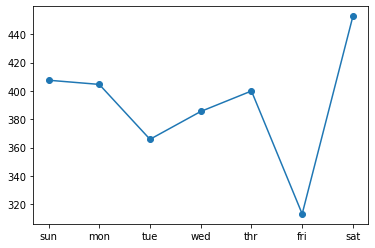

In [37]:
# evaluate model and get rmse value for 7 days input and ploting RMSE error in power concumptiom
## Printing the for overall and individual days of the week. 
we_input = 7
train, test = split_df(df.values)
score, scores = evaluate(train, test, we_input)
sumup_scores('lstm', score, scores)  
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

lstm: [370.915] 369.3, 387.2, 348.9, 371.3, 375.5, 299.2, 432.0


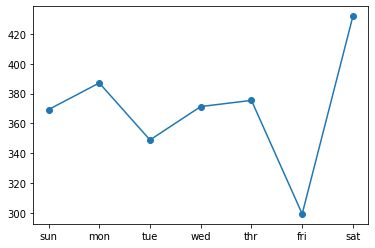

In [38]:
# evaluate model and get rmse value for 14 days input and ploting RMSE error in power concumptiom
we_input = 14
train, test = split_df(df.values)
score, scores = evaluate(train, test, we_input)
sumup_scores('lstm', score, scores)  
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

lstm: [370.628] 387.7, 360.9, 338.4, 382.7, 375.9, 288.8, 441.9


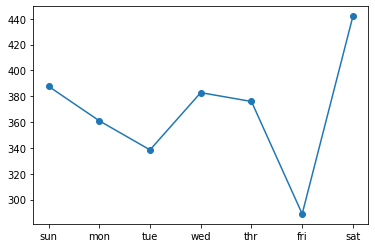

In [39]:
# evaluate model and get rmse value for 21 days input and  ploting RMSE error in power concumptiom
we_input = 21
train, test = split_df(df.values)
score, scores = evaluate(train, test, we_input)
sumup_scores('lstm', score, scores)  
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

lstm: [387.332] 414.8, 387.6, 344.1, 384.5, 362.0, 314.9, 481.0


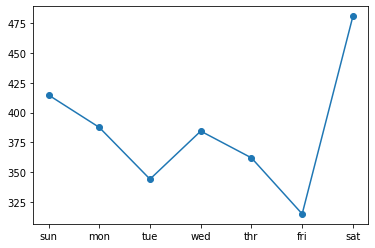

In [20]:
# evaluate model and get rmse value for 28 days input and ploting RMSE error in power concumptiom
we_input = 28
train, test = split_df(df.values)
score, scores = evaluate(train, test, we_input)
sumup_scores('lstm', score, scores)  
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [21]:
## obverving the results , It is easy to forecast on Tuesdays and fridays compared to weekend on saturdays.    
